In [59]:
import math
from typing import Callable, Tuple
from abc import ABC, abstractmethod
import itertools
import time

from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, IntSlider, Text, HBox, FloatLogSlider, VBox
from IPython.display import display
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import pint
units = pint.UnitRegistry()

%matplotlib inline

In [37]:
class PIDController:
    def __init__(self, setpoint, initial, p, i, izone, d, f, ts, system, voltage=1*units.volt):
        self.setpoint = setpoint
        self.initial = initial
        self.p = p
        self.i = i
        self.izone = izone
        self.d = d
        self.f = f
        self.ts = ts
        self.system = system
        self.voltage = voltage

    @property
    def times(self):
        t = 0 * units.second
        while True:
            yield t
            t += self.ts

    def __call__(self):
      err_acc = 0 * units.degree * units.second
      last_err = 0 * units.degree
      last_time = None
      position = self.initial
      velocity = 0 * units.degree / units.second
      for time in self.times:
        err = self.setpoint - position
        Vf = self.voltage * self.system.feed_forward(self.setpoint, position, self.f)
        assert_dim(Vf, '[electric_potential]')
        Vp = self.voltage * self.p * err
        assert_dim(Vp, '[electric_potential]')
        if last_time is not None:
          d_time = (time - last_time)
          d_err = (err - last_err) / d_time
          Vd = self.voltage * self.d * d_err
          assert_dim(Vd, '[electric_potential]')
          if abs(err) < self.izone:
            err_acc += err * d_time
          else:
            err_acc = 0 * units.degree * units.second
          Vi = self.voltage * self.i * err_acc
          assert_dim(Vi, '[electric_potential]')
        else:
          (Vd, Vi, d_err, d_time) = (0*units.volt, 0*units.volt, 0 / units.second, self.ts)
        V = Vf + Vp + Vd + Vi
        V = self.voltage if V > self.voltage else -self.voltage if V < -self.voltage else V

        position, velocity = self.system.process(position, velocity, V, d_time)
        yield (time, self.setpoint, position, velocity, V, Vf, Vp, Vi, Vd, err, d_err, err_acc)
        (last_time, last_err) = (time, err)

In [38]:
def check_return(dim):
    def decorator(f):
        def wrapper(*args, **kwargs):
            result = f(*args, **kwargs)
            assert result.check(dim), f"{f} did not return {dim}"
            return result
        return wrapper
    return decorator


def assert_dim(value, dim):
    assert value.check(dim), f"{value} does not have dimension {dim}"
    

class Motor():    
    def __init__(self, nominal_voltage, free_speed, stall_torque, free_current, stall_current):
        self.nominal_voltage = nominal_voltage
        self.free_speed = free_speed
        self.stall_torque = stall_torque
        self.free_current = free_current
        self.stall_current = stall_current
        
        self.resistance = self.nominal_voltage / self.stall_current
        assert self.resistance.check('[resistance]')
        self.k_i = self.nominal_voltage * (1 - self.free_current / self.stall_current) / self.free_speed
        assert self.k_i.check('[electric_potential]/[frequency]')
        self.k_t = self.stall_torque / (self.stall_current - self.free_current)
        assert self.k_t.check('[torque]/[current]')
        self.friction_torque = self.k_t * self.free_current

    @check_return('[electric_potential]')
    def emf(self, angular_velocity: units.rpm, voltage: units.volt) -> units.volt:
        return self.k_i * angular_velocity
    
    @check_return('[current]')
    def current(self, angular_velocity: units.rpm, voltage: units.volt) -> units.amp:
        assert voltage.check('[electric_potential]')        
        emf = self.emf(angular_velocity, voltage)
        assert emf.check('[electric_potential]')
        residual_voltage = voltage - emf
        return residual_voltage / self.resistance
                
    @check_return('[torque]')
    def torque(self, angular_velocity: units.rpm, voltage: units.volt) -> units.newton * units.metre:
        assert_dim(angular_velocity, '[frequency]')
        assert_dim(voltage, '[electric_potential]')
        tau = self.k_t * self.current(angular_velocity, voltage)
        #tau -= self.friction_torque
        assert tau.check('[torque]')
        #return 0*units.newton*units.metre if tau < 0 else tau
        return tau
                
    @check_return('[power]')
    def output_power(self, angular_velocity: units.rpm, voltage: units.volt) -> units.watt:
        return self.torque(angular_velocity, voltage) * angular_velocity

    @check_return('[power]')
    def input_power(self, angular_velocity: units.rpm, voltage: units.volt) -> units.watt:
        return self.current(angular_velocity, voltage) * voltage

    def efficiency(self, angular_velocity: units.rpm, voltage: units.volt) -> float:
        return self.output_power(angular_velocity, voltage) / self.input_power(angular_velocity, voltage)
            
class Neo550(Motor):
    def __init__(self):
        super().__init__(
            nominal_voltage=12*units.volt,
            free_speed=10000*units.rpm,
            stall_torque=0.97*units.newton*units.metre,
            free_current=1.4*units.amp,
            stall_current=100*units.amp)        

In [39]:
class System(ABC):
    def feed_forward(self, setpoint, position, f):
        pass
    
    def process(self, position, angular_velocity, ts):
        pass

class Arm(System):
    def __init__(self, mass, length, motor):
        self.motor = motor
        self.mass = mass
        self.length = length
        
        self.moment_of_inertia = self.mass * self.length **2 / 3
        g = 9.8 * units.metre / units.second / units.second
        self.maximum_gravity_torque = -g * self.mass * self.length/2
        
    def feed_forward(self, setpoint, position, f):
        return f * math.cos(setpoint)

    def angular_acceleration(self, position, angular_velocity, voltage):
        gravity_torque = self.maximum_gravity_torque * math.cos(position)
        motor_torque = self.motor.torque(angular_velocity, voltage)
        friction_torque = self.motor.friction_torque
        torque = gravity_torque + motor_torque
        if friction_torque > abs(torque):
            torque = 0 * units.newton * units.metre
        elif torque > 0:
            torque -= friction_torque
        else:
            torque -= friction_torque
        aa = torque / self.moment_of_inertia
        aa.check('[]/[time]**2')
        #print(f"{position=}, {angular_velocity=}, {voltage=}, {gravity_torque=}, {motor_torque=}, {aa=}")
        return aa
        
    def process(self, p0, v0, voltage, ts):
        assert_dim(p0, '[]')
        assert_dim(v0, '[frequency]')
        assert_dim(voltage, '[electric_potential]')
        assert_dim(ts, '[time]')
        # Huen's method for trapezoidal interpolation
        # https://github.com/robotpy/pyfrc/blob/main/pyfrc/physics/tankmodel.py
        # https://en.wikipedia.org/wiki/Heun%27s_method
        a0 = self.angular_acceleration(p0, v0, voltage)
        v1 = v0 + a0 * ts
        p1 = p0 + ts * (v0 + v1) / 2
        a1 = self.angular_acceleration(p1, v1, voltage)
        #print(f"{p0=} {v0=} {a0=} {v1=}, {a1=}")
        v1 = v0 + ts * (a0 + a1) / 2
        p1 = p0 + ts * (v0 + v1) / 2
        #print(f"{v1=}, {p1=}")
        #a1 = self.angular_acceleration(p1, v1, voltage)
        #v1 = v0 + ts * (a0 + a1) / 2
        #p1 = p0 + ts * (v0 + v1) / 2
        
        p1 = p1-360 if p1 > 180 else p1+360 if p1 < -180 else p1
        return (p1, v1)

In [40]:
def analyze(df):
  max_error = df.err.abs().max()
  end = int(len(df)*0.98) # last 10% of data
  #max_end_error = df.err.iloc[end:].abs().max()
  initial_error = df.iloc[0].err
  steady_state_error = abs(df.err.iloc[end:].mean())
  if steady_state_error < initial_error * 0.5:
    try:
      settling_time = df[(df.err - steady_state_error).abs().gt(0.02 * abs(steady_state_error - initial_error))].index[-1]
    except IndexError:
      settling_time = df.index[-1]
    least_error = df.err.min()
    greatest_error = df.err.max()
    overshoot = abs((least_error - steady_state_error) / (initial_error - steady_state_error))
    return(steady_state_error, settling_time, overshoot)
  else:
    return (None, None, None)

In [52]:
class Widget:
    def __init__(self, name, cls, min, max, step=None, readout_format='f', value=None, unit=1):
        self.name = name
        self.widget = cls(min=min, max=max, step=step, value=value, readout_format=readout_format, description=name)
        self.unit = unit
        self.widget.layout = Layout(width='auto')
        #display(self.widget)
        
    @property
    def value(self):
        return self.widget.value * self.unit

    def observe(self, handler):
        self.widget.observe(handler, names='value')
        
    def display(self):
        display(self.widget)

    
class Main: 
    
    graphs = [
        (["setpoint", "position"], None),
        (["V", "Vf", "Vp", "Vi", "Vd"], (-12, 12)),
        (["velocity"], None),
        (["err"], (-180,180)),
        (["delta_err"], None),
        (["total_err"], None),
    ]

    def __init__(self):
        self.motor = Neo550()
        self.system = Arm(mass=20*units.pound, length=2*units.foot, motor=self.motor)
        self.output = widgets.Output()
        with self.output:
            self.fig, self.axes = plt.subplots(nrows=6, figsize=(30,5*len(self.graphs)))
        self.create_widgets()
        self.lines = None
        self.initial = -90 * units.degree
        self.izone = 20 * units.degree
        
        self.df = self.event_handler()

    def create_widgets(self):
        self.widgets = { w.name: w for w in [
            Widget(name='p', cls=FloatSlider, min=0., max=0.1, step=0.001, readout_format='0.4f', unit=1/units.degree),
            Widget(name='i', cls=FloatSlider, min=0., max=0.01, step=0.0001, readout_format='0.4f', unit=1/(units.degree*units.second)),
            Widget(name='d', cls=FloatSlider, min=0., max=1., step=0.01, readout_format='0.4f', unit=units.second/units.degree),
            Widget(name='f', cls=FloatSlider, min=0., max=1., step=0.01, readout_format='0.4f', unit=1),
            Widget(name='setpoint', cls=IntSlider, min=-90, max=+90, unit=units.degree),
            Widget(name='t', cls=IntSlider, value=120, min=10, max=120, step=1, readout_format='d', unit=units.second),
            Widget(name='ts', cls=FloatLogSlider, value=1., min=-2, max=0., step=0.1, readout_format='0.2f', unit=units.second),
        ] }
        for widget in self.widgets.values():
            widget.observe(self.event_handler)
        
        page = VBox([*[x.widget for x in self.widgets.values()], self.output])
        display(page)
        
        
    def get_df(self, controller, n_steps):
        data = itertools.islice(controller(), n_steps)
        data = [ [ x.to_tuple()[0] for x in row ] for row in data ]
        df = pd.DataFrame(columns=["time", "setpoint", "position", "velocity", "V", "Vf", "Vp", "Vi", "Vd", "err", "delta_err", "total_err"],
                          data=data)
        df.index = df.time
        return df
        
    def event_handler(self, change=None):
        print(f"event_handler: {change}")
        start_time = time.time()
        setpoint = self.widgets['setpoint'].value
        p = self.widgets['p'].value
        i = self.widgets['i'].value
        d = self.widgets['d'].value
        f = self.widgets['f'].value
        t = self.widgets['t'].value
        ts = self.widgets['ts'].value
        print(f"widgets read in {time.time() - start_time}s")

        start_time = time.time()
        n_steps = int(t / ts)
        controller = PIDController(setpoint, self.initial, p, i, self.izone, d, f, ts, self.system, voltage=12*units.volt)
        df = self.get_df(controller, n_steps)
        print(f"df gotten in {time.time() - start_time}s")
        #self.fig, self.axes = plt.subplots(nrows=6, figsize=(30,5*len(self.graphs)))
        start_time = time.time()
        if self.lines is None:
            self.lines = []
            for ax, g in zip(self.axes, self.graphs):
                lines = []
                for key in g[0]:
                    line, = ax.plot(df.index, df[key], label=key)
                    lines.append(line)
                self.lines.append(lines)
                ax.ylim = g[1]
                ax.legend()
                #lines = df[g[0]].plot(ax=ax, grid=True, ylim=g[1]).get_lines()
        else:
            for lines, g in zip(self.lines, self.graphs):
                for line, key in zip(lines, g[0]):
                    line.set_ydata(df[[key]])
        self.fig.canvas.draw()
        #plt.show()
        print(f"graphs plotted in {time.time() - start_time}s")
        #print(df)
        return df

event_handler: None
widgets read in 0.0001354217529296875s
df gotten in 0.21318268775939941s
graphs plotted in 0.6680636405944824s


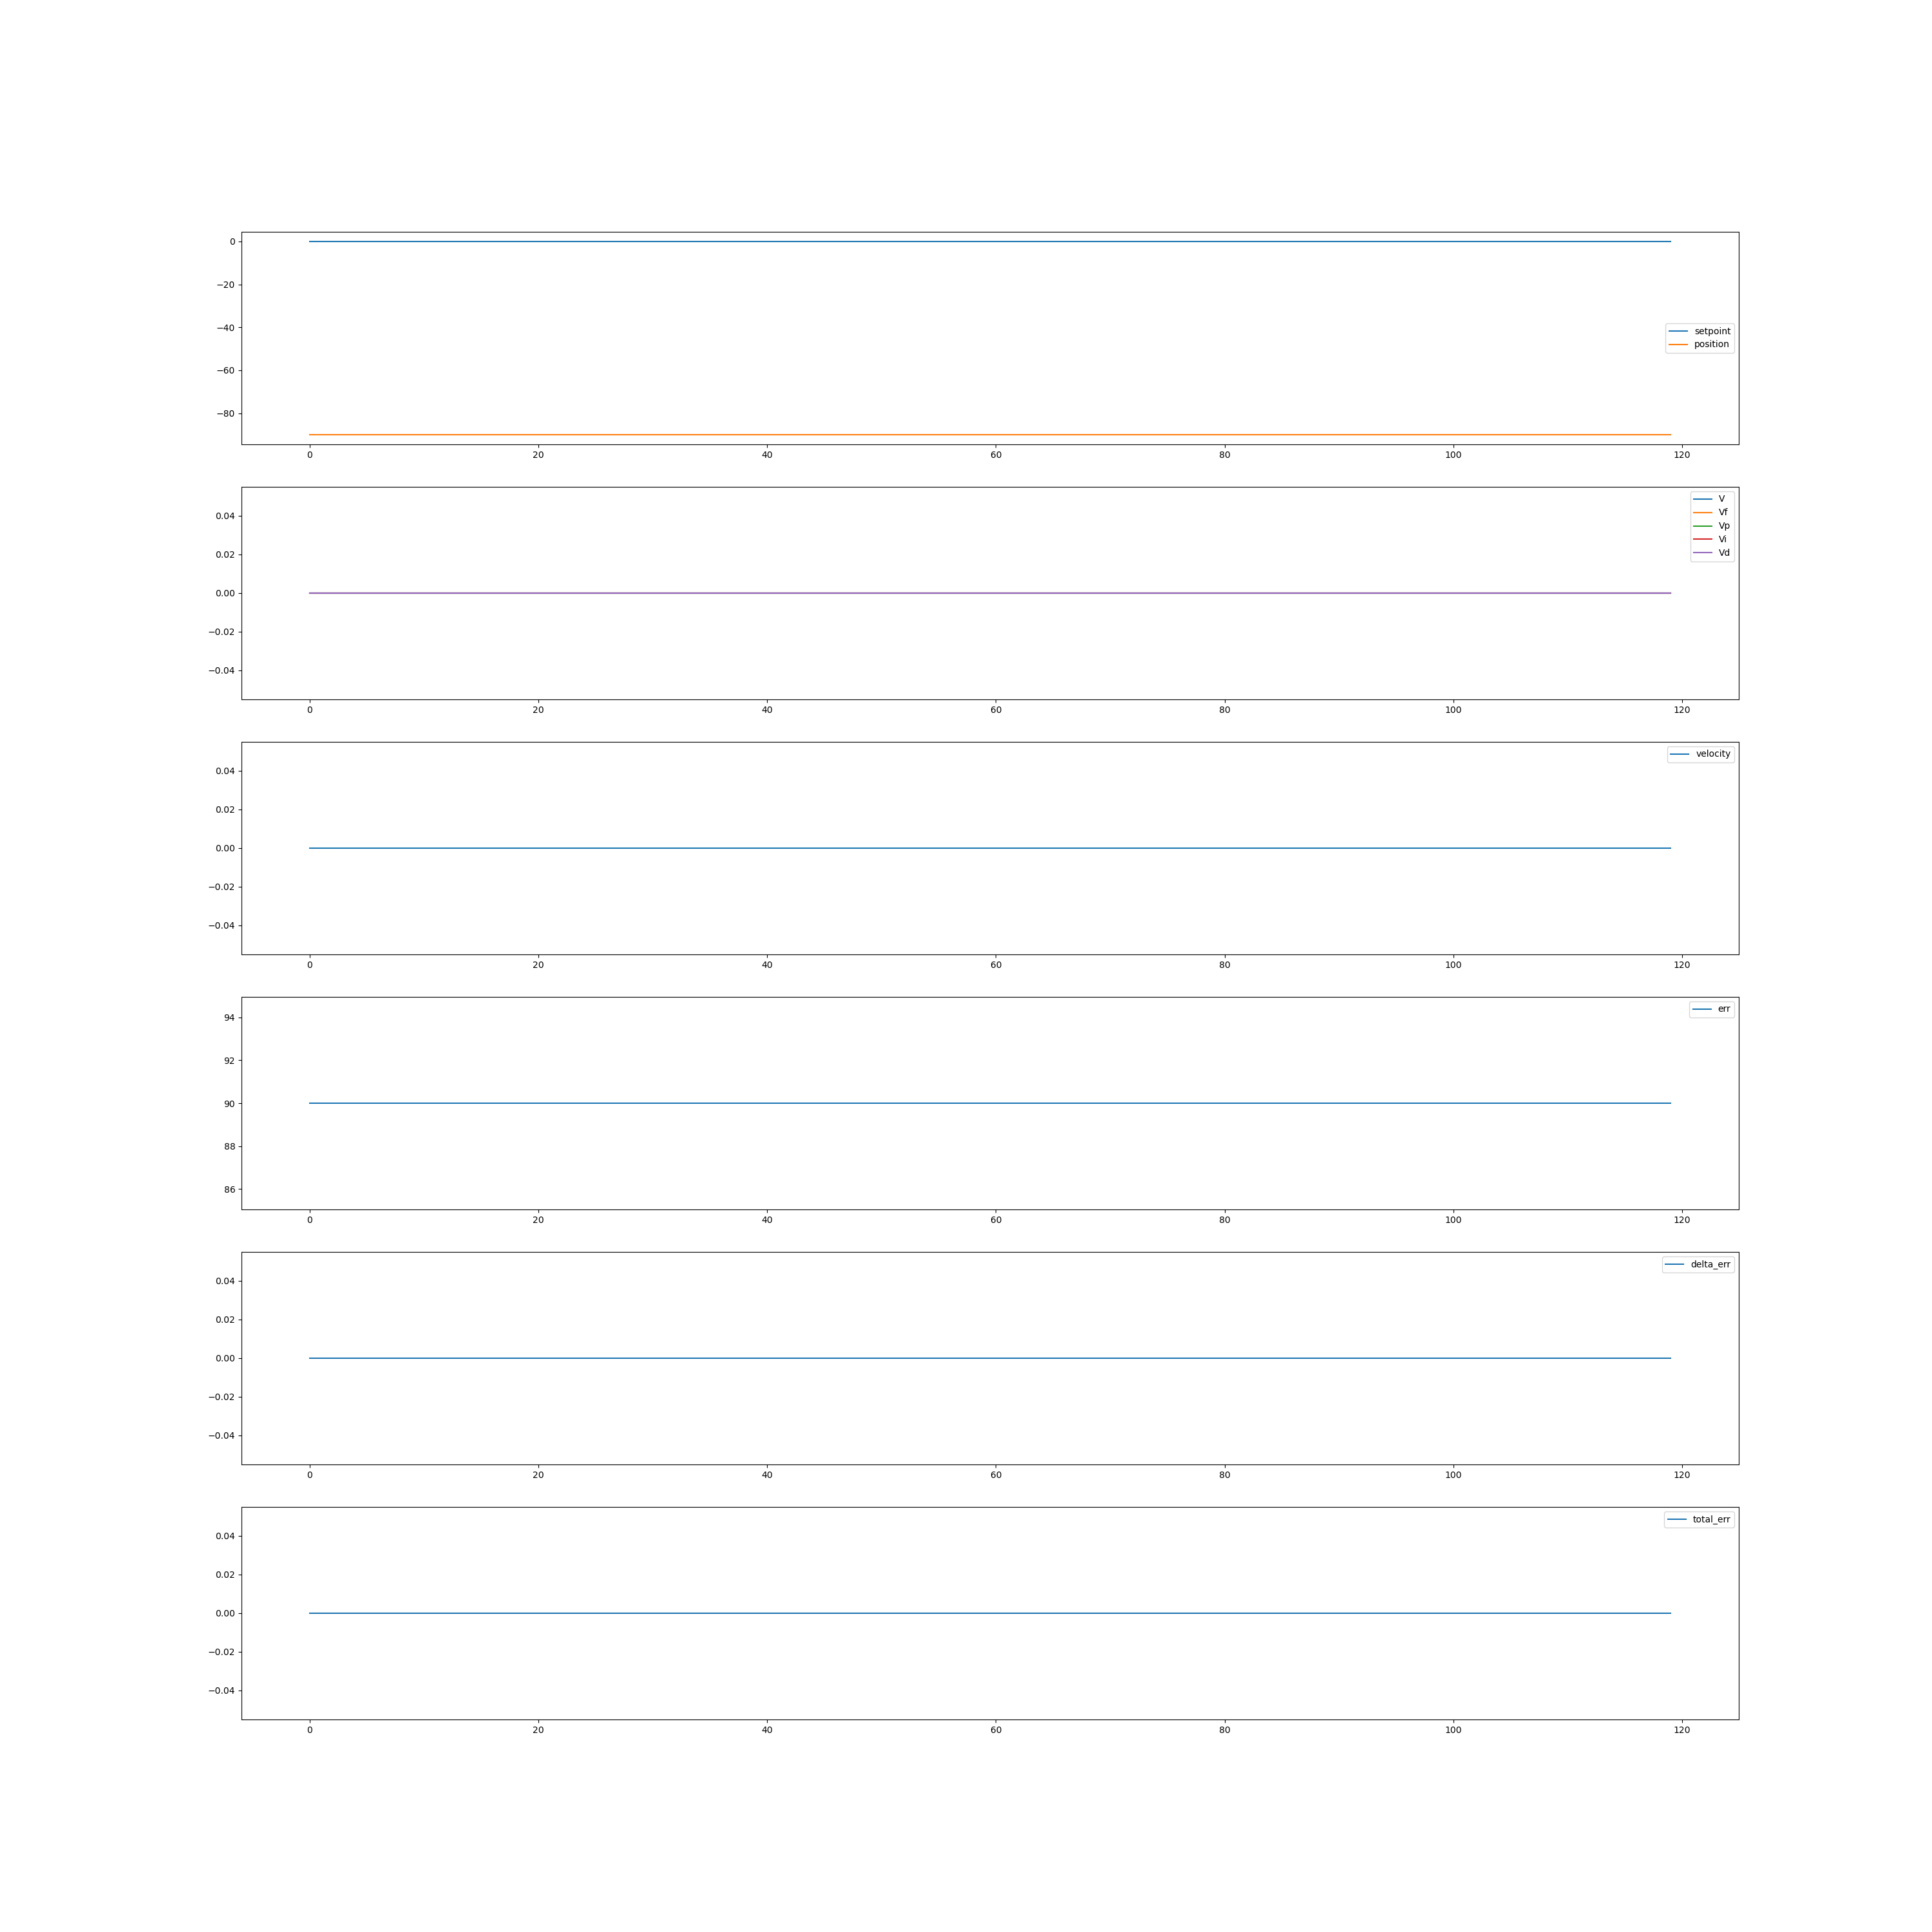

In [54]:
df = Main().df

p=0.0100, i=0.0009, d=0.0300, f=0.1000